# Goal: Predict whether a user will repay their loan or default based on their smartphone data

Features to use:

    - total number of calls
    
    - total number of texts
    
    - Number of unique contacts
    
    - length of digital history
    
    - number of contacts they often call (> 10 tims)
    
    - % of inbox sms and % of sent sms

In [42]:
import glob
import time
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, roc_curve, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../logs/users.csv')
user_ids = df.user_id.values

In [6]:
# total number of calls
count_of_call = []
for uid in user_ids:
    devices = glob.glob('../logs/user-%d/*' %uid)
    call_logs = []
    call_logs += [glob.glob(d+'/collated_call_log.txt') for d in devices]
    total_call = 0
    for call_log in call_logs:
        if len(call_log) > 0:  # filter the users that don't have a call log
            df_call = pd.read_json(call_log[0])
            if len(df_call) > 0:  #  if not empty call logs, accumlate count
                total_call += len(df_call)
    count_of_call.append(total_call)

In [7]:
# total number of texts
count_of_text = []
for uid in user_ids:
    devices = glob.glob('../logs/user-%d/*' %uid)
    sms_logs = []
    sms_logs += [glob.glob(d+'/collated_sms_log.txt') for d in devices]
    total_text = 0
    for sms_log in sms_logs:
        if len(sms_log) > 0:
            df_sms = pd.read_json(sms_log[0])
            if len(df_sms) > 0:
                total_text += len(df_sms)
    count_of_text.append(total_text)

In [8]:
# number of unique contacts
count_of_contacts = []
for uid in user_ids:
    devices = glob.glob('../logs/user-%d/*' %uid)
    contact_lists = []
    contact_lists += [glob.glob(d+'/collated_contact_list.txt') for d in devices]
    contact_list_length = 0
    all_contacts = []
    for contact_list in contact_lists:
        if len(contact_list) > 0:  # filter the users that don't have a call log
            df_contact = pd.read_json(contact_list[0])
            if len(df_contact) > 0:  #  if not empty call logs, accumlate count
                all_contacts += df_contact['display_name'].values.tolist()
    unique_contact = len(set(all_contacts))
    count_of_contacts.append(unique_contact)

In [9]:
# length of digital history
length_digital_history = []
for uid in user_ids:
    devices = glob.glob('../logs/user-%d/*' %uid)
    call_logs = []
    call_logs += [glob.glob(d+'/collated_call_log.txt') for d in devices]  
    dates = []  # storing the first day and last day in each log
    for call_log in call_logs:
        if len(call_log) > 0:  # filter the users that don't have a call log
            df_call = pd.read_json(call_log[0])
            if len(df_call) > 0:  #  if not empty call logs, accumlate count
                dates.append(min(df_call.datetime))
                dates.append(max(df_call.datetime))

    length_digital_history.append(max(dates) - min(dates))

In [10]:
# number of contacts they often call
often_contacts = []
for uid in user_ids:
    devices = glob.glob('../logs/user-%d/*' %uid)
    contact_lists = []
    contact_lists += [glob.glob(d+'/collated_contact_list.txt') for d in devices]
    count_often_contact = 0
    for contact_list in contact_lists:
        if len(contact_list) > 0:  # filter the users that don't have a contact lists
            df_contact = pd.read_json(contact_list[0])
            if len(df_contact) > 0:  #  if not empty contact list, accumlate count
                count_often_contact += sum(df_contact['times_contacted'] > 10)
    often_contacts.append(count_often_contact)

In [14]:
# percentage inbox sms
count_of_type1 = []
for uid in user_ids:
    devices = glob.glob('../logs/user-%d/*' %uid)
    sms_logs = []
    sms_logs += [glob.glob(d+'/collated_sms_log.txt') for d in devices]
    total_text = 0
    inbox_text = 0
    for sms_log in sms_logs:
        if len(sms_log) > 0:
            df_sms = pd.read_json(sms_log[0])
            if len(df_sms) > 0:
                total_text += len(df_sms)
                inbox_text += len(df_sms[df_sms['sms_type'] == 1])
    count_of_type1.append(inbox_text*100.0/total_text)

In [15]:
# percentage sent sms
count_of_type2 = []
for uid in user_ids:
    devices = glob.glob('../logs/user-%d/*' %uid)
    sms_logs = []
    sms_logs += [glob.glob(d+'/collated_sms_log.txt') for d in devices]
    total_text = 0
    sent_text = 0
    for sms_log in sms_logs:
        if len(sms_log) > 0:
            df_sms = pd.read_json(sms_log[0])
            if len(df_sms) > 0:
                total_text += len(df_sms)
                sent_text += len(df_sms[df_sms['sms_type'] == 2])
    count_of_type2.append(sent_text*100.0/total_text)

In [17]:
df['total_calls'] = count_of_call
df['total_sms'] = count_of_text
df['total_unique_contacts'] = count_of_contacts
df['digital_history_length'] = length_digital_history
df['digital_history_length'] = df['digital_history_length'].dt.days ## convert it to days
df['total_often_contacts'] = often_contacts
df['percentage_type1_sms'] = count_of_type1
df['percentage_type2_sms'] = count_of_type2

In [20]:
df = df.sample(frac = 1)
df['repaid'] = df['loan_status'] == 'repaid'
df['repaid'] = df['repaid'].apply(int)

In [21]:
df.head(5)

,user_id,disbursed_at,loan_status,total_calls,total_sms,total_unique_contacts,digital_history_length,total_often_contacts,percentage_type1_sms,percentage_type2_sms,repaid
29,30,2017-03-02T00:00:00.000Z,repaid,3011,820,402,1336,70,75.121951,24.756098,1
249,250,2017-03-02T00:00:00.000Z,defaulted,324,16,207,14,3,100.000000,0.000000,0
91,92,2017-03-02T00:00:00.000Z,repaid,1500,1259,416,157,62,86.258936,12.470214,1
397,398,2017-03-01T00:00:00.000Z,defaulted,881,313,344,62,7,55.271565,44.728435,0
8,9,2017-03-02T00:00:00.000Z,repaid,973,185,98,81,16,76.216216,23.783784,1


In [22]:
trainX = df[['total_calls', 'total_sms', 'total_unique_contacts',
             'digital_history_length', 'total_often_contacts',
             'percentage_type1_sms', 'percentage_type2_sms']][:300]
trainY = df['repaid'][:300].values

testX = df[['total_calls', 'total_sms', 'total_unique_contacts',
             'digital_history_length', 'total_often_contacts',
             'percentage_type1_sms', 'percentage_type2_sms']][300:]
testY = df['repaid'][300:].values

In [25]:
rf_parameters = {'n_estimators':range(5, 51, 5), 'max_depth':range(1,11)}
rf_clf = GridSearchCV(RFC(), rf_parameters)
rf_clf.fit(trainX, trainY)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [53]:
rf_clf.best_params_, rf_clf.best_score_

({'max_depth': 3, 'n_estimators': 45}, 0.76333333333333331, 'raise')

In [32]:
pred = rf_clf.predict(testX)
pred_proba = rf_clf.predict_proba(testX)
sum(pred == testY)*100.0/len(testY)

71.0

In [46]:
logit_parameters = {'C':[10**i for i in range(-3, 4)]}
logit_clf = GridSearchCV(LR(), logit_parameters)
logit_clf.fit(trainX, trainY)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [47]:
logit_clf.best_params_, logit_clf.best_score_

({'C': 0.001}, 0.77000000000000002)

In [48]:
logit_pred = logit_clf.predict(testX)
logit_pred_proba = logit_clf.predict_proba(testX)
sum(logit_pred == testY)*100.0/len(testY)

70.0

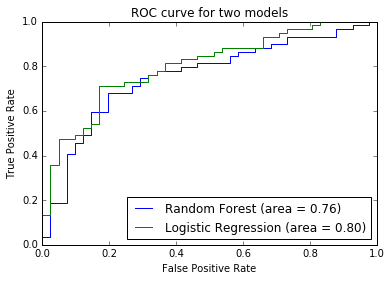

In [56]:
fpr, tpr, thresholds = roc_curve(testY, pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'Random Forest (area = %0.2f)' % roc_auc)
logit_fpr, logit_tpr, thresholds = roc_curve(testY, logit_pred_proba[:, 1])
logit_roc_auc = auc(logit_fpr, logit_tpr)
plt.plot(logit_fpr, logit_tpr, label = 'Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.title('ROC curve for two models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [38]:
model = RFC(n_estimators=45, max_depth=3)
model.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
for i, j in zip(trainX.columns, model.feature_importances_):
    print i, j

total_calls 0.434850418762
total_sms 0.143926640623
total_unique_contacts 0.0468165913396
digital_history_length 0.231819981872
total_often_contacts 0.0388586468985
percentage_type1_sms 0.0447851527772
percentage_type2_sms 0.0589425677277
